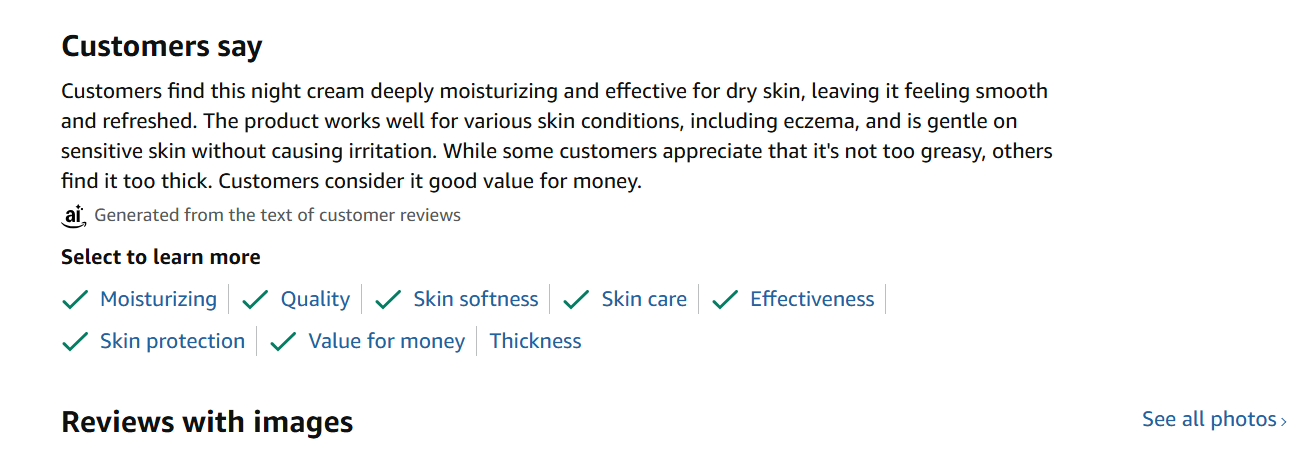

In [ ]:
import nltk
from google.colab import drive
import pandas as pd
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

# This doesn't work

In [ ]:
# df = pd.read_json("/content/drive/MyDrive/AmazonReviews'23/Beauty_and_Personal_Care.jsonl")
# df.head()

## So do chunk it out instead

In [ ]:
import pandas as pd
import random
import json
import os
from sklearn.model_selection import train_test_split

# --- Configuration ---
JSONL_FILE_PATH = "/content/drive/MyDrive/AmazonReviews'23/Beauty_and_Personal_Care.jsonl" # Update with your exact file name
# Common column names for Amazon Review data:
TEXT_COLUMN_NAME = 'text'
# You might need to adjust TEXT_COLUMN_NAME based on your specific JSON structure
SAMPLE_FRACTION = 0.30 # The fraction you want to keep (30%)
RANDOM_SEED = 42
output_dir = "/content/drive/MyDrive/AmazonReviews'23/"
os.makedirs(output_dir, exist_ok=True)


def load_and_sample_jsonl_iterative(file_path: str, frac: float, text_col: str, random_seed: int) -> pd.DataFrame:
    """
    Reads a large JSONL file line-by-line, randomly samples a fraction,
    and extracts only the specified text column to prevent memory crash.
    """
    random.seed(random_seed)
    sampled_records = []

    # Simple line count for progress tracking (this might take a minute, but is memory-safe)
    print("Estimating total lines (23.9M reviews)...")
    total_lines = 23900000 # Using the metadata count for accuracy

    sample_probability = frac

    print(f"Starting line-by-line sampling (Probability: {sample_probability:.2%})...")

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # Only keep the line if a random number is below the sample probability
            if random.random() < sample_probability:
                try:
                    record = json.loads(line.strip())
                    # Only store the required text column, ensuring it exists and is a string
                    if text_col in record and isinstance(record[text_col], str):
                        sampled_records.append({text_col: record[text_col]})
                except json.JSONDecodeError:
                    # Skip malformed lines
                    continue

            if i % 1000000 == 0 and i > 0:
                print(f"Processed {i/1000000:.1f}M lines.")

    print(f"Sampling complete. Kept {len(sampled_records)} records.")
    return pd.DataFrame(sampled_records)


# --- EXECUTION: Sample the data ---
df_main_sample = load_and_sample_jsonl_iterative(
    file_path=JSONL_FILE_PATH,
    frac=SAMPLE_FRACTION,
    text_col=TEXT_COLUMN_NAME,
    random_seed=RANDOM_SEED
)

# --- Split the Sampled Data into Train and Test ---
# Set aside the final, untouched test set from your 30% sample.
df_train_raw, df_test = train_test_split(
    df_main_sample,
    test_size=0.33, # This makes the test set approx. 10% of the original full data
    random_state=RANDOM_SEED
)

# --- Save the Results ---
train_file = os.path.join(output_dir, 'train_topic_pool.csv')
test_file = os.path.join(output_dir, 'test_final_untouched.csv')

df_train_raw.to_csv(train_file, index=False)
df_test.to_csv(test_file, index=False)

print("\n--- FINAL DATA PREPARATION COMPLETE ---")
print(f"1. Training/Topic Modeling Pool saved: {train_file} ({len(df_train_raw)} reviews)")
print(f"2. Final Test Benchmark saved (DO NOT TOUCH): {test_file} ({len(df_test)} reviews)")

Estimating total lines (23.9M reviews)...
Starting line-by-line sampling (Probability: 30.00%)...
Processed 1.0M lines.
Processed 2.0M lines.
Processed 3.0M lines.
Processed 4.0M lines.
Processed 5.0M lines.
Processed 6.0M lines.
Processed 7.0M lines.
Processed 8.0M lines.
Processed 9.0M lines.
Processed 10.0M lines.
Processed 11.0M lines.
Processed 12.0M lines.
Processed 13.0M lines.
Processed 14.0M lines.
Processed 15.0M lines.
Processed 16.0M lines.
Processed 17.0M lines.
Processed 18.0M lines.
Processed 19.0M lines.
Processed 20.0M lines.
Processed 21.0M lines.
Processed 22.0M lines.
Processed 23.0M lines.
Sampling complete. Kept 7176684 records.

--- FINAL DATA PREPARATION COMPLETE ---
1. Training/Topic Modeling Pool saved: /content/drive/MyDrive/AmazonReviews'23/train_topic_pool.csv (4808378 reviews)
2. Final Test Benchmark saved (DO NOT TOUCH): /content/drive/MyDrive/AmazonReviews'23/test_final_untouched.csv (2368306 reviews)


## Checkpoint 1: train_topic_pool.csv

In [ ]:
df_train_raw = pd.read_csv("/content/drive/MyDrive/AmazonReviews'23/train_topic_pool.csv")

In [ ]:
df_train_raw.head()

,text
0,Value for moneu
1,This is not real purpose soap and is yellow. I...
2,"This is a great brightener, I love it. I highl..."
3,This is just horrible. Doesn’t do a good job a...
4,Photos online are so decieving!!!! The little ...


In [ ]:
df_train_raw.iloc[1].values

array(["This is not real purpose soap and is yellow. I can't believe they are selling this as purpose. Looks and smells like the bottles have been filled with baby shampoo."],
      dtype=object)

# Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
# Download necessary resources if you haven't already
# nltk.download(['punkt', 'stopwords'])

# --- Only pre-compile regex patterns once ---
# Pattern to remove URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')
# Optimized emoji pattern
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)

def clean_for_bert(text):
    """
    Preprocessing optimized for pre-trained language models (like BERT).
    Focuses on removing noise while preserving syntax and case.
    """
    if not isinstance(text, str):
        return "" # Handle non-string inputs safely

    text = text.lower()  # Lowercase is generally safe and simplifies vocabulary

    # 1. Remove URLs
    text = url_pattern.sub(r'', text)

    # 2. Remove Emojis
    text = emoji_pattern.sub(r'', text)

    # 3. Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    # 4. Remove typical Amazon review noise (if present, e.g., "Vine Customer Review")
    text = re.sub(r'(vine customer review|verified purchase)', '', text, flags=re.IGNORECASE)

    # Do NOT remove punctuation, stopwords, or perform stemming/lemmatization for BERT!
    # BERT's internal Tokenizer and Model handle this better.

    return text

df_train_raw["text"] = df_train_raw["text"].apply(clean_for_bert)

In [ ]:
df_train_raw.head()

,text
0,value for moneu
1,this is not real purpose soap and is yellow. i...
2,"this is a great brightener, i love it. i highl..."
3,this is just horrible. doesn’t do a good job a...
4,photos online are so decieving!!!! the little ...


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Assuming you have already run clean_for_bert() on your data
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet') # WordNet is needed for lemmatization
import nltk
nltk.download('stopwords')
# nltk.download('punkt') # Punkt tokenizer is usually included
# nltk.download('punkt_tab') # This resource seems to be causing issues


lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

def clean_for_topic_modeling(text):
    """
    Aggressive cleaning for Topic Models (LDA/BERTopic).
    Removes stopwords and reduces words to their root form (lemmatization).
    """
    # Start from the BERT-cleaned text

    # 1. Remove punctuation (Topic Models prefer clean tokens)
    text = re.sub(r'[^\w\s]', '', text)

    # 2. Tokenize and remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in english_stopwords and word.isalpha()]

    # 3. Lemmatization (better than stemming for topic coherence)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 4. Filter out short words (e.g., single letters) that don't add meaning
    tokens = [word for word in tokens if len(word) > 2]

    return " ".join(tokens)

# This output is only used for LDA/BERTopic modeling!
df_train_raw["topic_text"] = df_train_raw["text"].apply(clean_for_topic_modeling)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Save checkpoint to avoid crash in google colab

In [ ]:
import os
output_dir = "/content/drive/MyDrive/AmazonReviews'23/"
train_file = os.path.join(output_dir, 'train_topic_pool.csv')
df_train_raw.to_csv(train_file, index=False)

## Checkpoint 2: preprocessed text

In [ ]:
df_train_raw = pd.read_csv("/content/drive/MyDrive/AmazonReviews'23/train_topic_pool.csv")

In [ ]:
df_train_raw.head()

,text,topic_text
0,value for moneu,value moneu
1,this is not real purpose soap and is yellow. i...,real purpose soap yellow cant believe selling ...
2,"this is a great brightener, i love it. i highl...",great brightener love highly recommend
3,this is just horrible. doesn’t do a good job a...,horrible doesnt good job guard marked want ret...
4,photos online are so decieving!!!! the little ...,photo online decieving little round flower sho...


# Chunking data into 3 part to processed it

In [ ]:
import json
import os
import itertools
import pandas as pd # Needed only for the final cleaning step

# --- Configuration ---
JSONL_FILE_PATH = 'review_categories/All_Beauty.jsonl'
TEXT_COLUMN_NAME = 'text'
# The size of the chunk you can safely hold and process in Colab RAM.
# Start small (e.g., 500,000 lines) and test memory usage.
CHUNK_SIZE = 500000
OUTPUT_TOKENS_FILE = 'data/full_topic_tokens.txt'
CHECKPOINT_FILE = 'data/checkpoint.txt'


def load_and_process_chunks(file_path: str, text_col: str, chunk_size: int):
    # --- 1. Load Checkpoint ---
    start_line = 0
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'r') as f:
            start_line = int(f.read().strip())
        print(f"Resuming processing from line {start_line}...")

    # --- 2. Main Processing Loop ---
    with open(file_path, 'r', encoding='utf-8') as infile, \
         open(OUTPUT_TOKENS_FILE, 'a', encoding='utf-8') as outfile:

        # Skip previously processed lines
        file_iterator = itertools.islice(infile, start_line, None)

        chunk_count = start_line // chunk_size

        while True:
            # Read the next chunk_size lines
            chunk = list(itertools.islice(file_iterator, chunk_size))

            if not chunk:
                print("--- Processing Complete ---")
                break # Reached the end of the file

            # Convert lines to Python objects and extract text
            reviews = []
            for line in chunk:
                try:
                    reviews.append(json.loads(line.strip()).get(text_col, ''))
                except json.JSONDecodeError:
                    continue

            # Create a temporary DataFrame for easy application of cleaning logic
            # (Replace with your optimized aggressive_clean_and_tokenize function)
            temp_df = pd.DataFrame({text_col: reviews})

            # Apply your AGGRESSIVE_CLEAN_AND_TOKENIZE function here
            # For demonstration, let's just use a simple placeholder processing:
            # You must insert your actual tokenization function here!
            temp_df['processed_text'] = temp_df[text_col].apply(
                clean_for_topic_modeling
            )

            # Write processed text to the output file, one document per line
            for text in temp_df['processed_text']:
                outfile.write(text + '\n')

            # Update the checkpoint after successful processing
            start_line += len(chunk)
            with open(CHECKPOINT_FILE, 'w') as chk_file:
                chk_file.write(str(start_line))

            chunk_count += 1
            print(f"Chunk {chunk_count} processed. Total lines processed: {start_line}")

# --- EXECUTION ---
# You need to ensure your aggressive_clean_and_tokenize function is defined/imported here!
# load_and_process_chunks(JSONL_FILE_PATH, TEXT_COLUMN_NAME, CHUNK_SIZE)

# Topic Modelling

3 Technique to performs:
- Frequency of unigram, bigram
- LDA, LSA
- BERT

## Frequency (unigram, bigram)

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from itertools import chain

def get_unigram_counts(token_lists):
    """Counts the frequency of all unique unigrams (single words)."""
    # Ensure input is treated as a string for safety
    token_lists = [str(item) for item in token_lists]
    # Flattens the list of lists into a single list of all tokens
    all_tokens = list(chain.from_iterable([item.split() for item in token_lists]))
    return Counter(all_tokens).most_common(20) # Top 20


# --- 5. Execution and Output ---
top_unigrams = get_unigram_counts(df_train_raw['topic_text'])


print("--- Top 20 Unigram Frequencies ---")
print(pd.DataFrame(top_unigrams, columns=['Unigram', 'Count']))



--- Top 20 Unigram Frequencies ---
    Unigram    Count
0      hair  1361219
1   product  1287300
2     great   997122
3      love   991870
4      like   908370
5       use   878681
6      good   691459
7      work   662860
8       one   652769
9      skin   613774
10    smell   508254
11   really   506734
12      get   503399
13     well   492196
14     time   468992
15     used   460772
16    would   457413
17    color   440855
18    using   388017
19     dont   384088


In [ ]:
from collections import Counter
from nltk.util import ngrams
import itertools
import pandas as pd

def get_bigram_counts_memory_safe(text_series: pd.Series, top_n: int = 20):
    """
    Counts bigram frequencies directly using a generator,
    avoiding the creation of a single massive list in memory.

    Assumes text_series contains a string of space-separated tokens
    (the output of your aggressive cleaning).
    """

    # --- 1. Define the Generator ---
    def bigram_generator():
        """Yields bigrams one at a time from the entire Series."""
        for text in text_series:
            # Ensure text is a string and split into tokens
            if isinstance(text, str):
                tokens = text.split()

                # Generate bigrams from these tokens
                for bigram_tuple in ngrams(tokens, 2):
                    yield " ".join(bigram_tuple)

    # --- 2. Count Directly from the Generator ---
    # Counter consumes the generated bigrams one-by-one,
    # only storing the unique bigrams and their counts.
    return Counter(bigram_generator()).most_common(top_n)

# --- Execution (Use your 4M review pool) ---
# Assuming 'df_train_raw' is loaded and 'topic_text' is the column
# containing the single string of cleaned, space-separated tokens.

top_bigrams_safe = get_bigram_counts_memory_safe(df_train_raw['topic_text'])

print("\n--- Top 20 Memory-Safe Bigram Frequencies ---")
print(pd.DataFrame(top_bigrams_safe, columns=['Bigram', 'Count']))


--- Top 20 Memory-Safe Bigram Frequencies ---
              Bigram   Count
0           easy use  116296
1      great product  113185
2         work great  113135
3          work well  109789
4       love product   79558
5   highly recommend   74377
6          feel like   58021
7           ive used   56207
8    would recommend   55997
9        really like   55986
10    sensitive skin   55965
11        first time   53899
12        smell like   50804
13         last long   50736
14         long time   50075
15       smell great   49587
16         look like   49424
17      good product   47572
18      good quality   46010
19        smell good   44568


### Sentimental Split

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

# Assuming df_train_raw is loaded and 'text' is the minimally cleaned review text column
# If you only have 'topic_text' (aggressively cleaned), you might need to use the original text.

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_category(text):
    """Calculates VADER compound score and assigns a category."""
    if not isinstance(text, str):
        return 'Neutral'

    score = analyzer.polarity_scores(text)['compound']

    # Define thresholds
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

print("Calculating sentiment for the training pool...")
# Apply the function to your text column (use the best available text)
df_train_raw['sentiment'] = df_train_raw['text'].apply(get_sentiment_category)
# Note: If 'text' is not available, use 'topic_text', but results may be less accurate.

print(df_train_raw['sentiment'].value_counts())

Calculating sentiment for the training pool...
sentiment
Positive    3699149
Negative     603381
Neutral      498939
Name: count, dtype: int64


In [ ]:
df_train_raw.head()

,text,topic_text,sentiment
0,value for moneu,value moneu,Positive
1,this is not real purpose soap and is yellow. i...,real purpose soap yellow cant believe selling ...,Positive
2,"this is a great brightener, i love it. i highl...",great brightener love highly recommend,Positive
3,this is just horrible. doesn’t do a good job a...,horrible doesnt good job guard marked want ret...,Negative
4,photos online are so decieving!!!! the little ...,photo online decieving little round flower sho...,Negative


In [ ]:
df_pos = df_train_raw[df_train_raw["sentiment"] == "Positive"]
df_neg = df_train_raw[df_train_raw["sentiment"] == "Negative"]
df_neu = df_train_raw[df_train_raw["sentiment"] == "Neutral"]

### Bigram Positive

In [ ]:
from collections import Counter
from nltk.util import ngrams
import itertools
import pandas as pd

def get_bigram_counts_memory_safe(text_series: pd.Series, top_n: int = 20):
    """
    Counts bigram frequencies directly using a generator,
    avoiding the creation of a single massive list in memory.

    Assumes text_series contains a string of space-separated tokens
    (the output of your aggressive cleaning).
    """

    # --- 1. Define the Generator ---
    def bigram_generator():
        """Yields bigrams one at a time from the entire Series."""
        for text in text_series:
            # Ensure text is a string and split into tokens
            if isinstance(text, str):
                tokens = text.split()

                # Generate bigrams from these tokens
                for bigram_tuple in ngrams(tokens, 2):
                    yield " ".join(bigram_tuple)

    # --- 2. Count Directly from the Generator ---
    # Counter consumes the generated bigrams one-by-one,
    # only storing the unique bigrams and their counts.
    return Counter(bigram_generator()).most_common(top_n)



top_bigrams_safe = get_bigram_counts_memory_safe(df_pos['topic_text'])

print("\n--- Top 20 Memory-Safe Bigram Frequencies ---")
print(pd.DataFrame(top_bigrams_safe, columns=['Bigram', 'Count']))


--- Top 20 Memory-Safe Bigram Frequencies ---
              Bigram   Count
0           easy use  113079
1      great product  110994
2         work great  110969
3          work well   99152
4       love product   76742
5   highly recommend   73059
6        really like   53228
7          feel like   51808
8        smell great   48051
9     sensitive skin   48003
10          ive used   47570
11   would recommend   46397
12         long time   44494
13      good product   44366
14      good quality   43590
15        first time   43351
16         last long   43094
17         look like   42109
18        smell like   41935
19       great price   41698


### Bigram Negative

In [ ]:
top_bigrams_safe = get_bigram_counts_memory_safe(df_neg['topic_text'])

print("\n--- Top 20 Memory-Safe Bigram Frequencies ---")
print(pd.DataFrame(top_bigrams_safe, columns=['Bigram', 'Count']))


--- Top 20 Memory-Safe Bigram Frequencies ---
             Bigram  Count
0       waste money  24887
1         work well   9112
2   would recommend   9085
3        first time   8567
4        smell like   8106
5        dont waste   7028
6         dont know   7007
7       doesnt work   6826
8         look like   6637
9          ive used   6620
10   sensitive skin   6276
11  stopped working   6219
12        dont like   5955
13       didnt work   5644
14        feel like   5569
15         dont buy   5213
16    using product   5137
17     nothing like   5127
18     poor quality   4797
19      worth money   4461


### Bigram Neutral

In [ ]:
top_bigrams_safe = get_bigram_counts_memory_safe(df_neu['topic_text'])

print("\n--- Top 20 Memory-Safe Bigram Frequencies ---")
print(pd.DataFrame(top_bigrams_safe, columns=['Bigram', 'Count']))


--- Top 20 Memory-Safe Bigram Frequencies ---
                Bigram  Count
0          doesnt work   3812
1            last long   3637
2           didnt work   3632
3            muy bueno   2885
4            make hair   2811
5        buen producto   2476
6          really work   2336
7            would buy   2324
8            hair soft   2248
9            long time   2241
10       using product   2219
11           muy buena   2067
12            ive used   2017
13  excelente producto   2015
14        used product   1998
15          first time   1981
16        product work   1807
17       thought would   1781
18       buena calidad   1745
19            dry skin   1735


## Save checkpoint 3

In [ ]:
import os
output_dir = "/content/drive/MyDrive/AmazonReviews'23/"
train_file = os.path.join(output_dir, 'train_topic_pool.csv')
df_train_raw.to_csv(train_file, index=False)

## LDA

## Checkpoint 3: preprocessed reviews with basic sentimental tag

In [ ]:
df_train_raw = pd.read_csv("/content/drive/MyDrive/AmazonReviews'23/train_topic_pool.csv")
df_train_raw.head()

In [ ]:
df_pos = df_train_raw[df_train_raw["sentiment"] == "Positive"]
df_neg = df_train_raw[df_train_raw["sentiment"] == "Negative"]
df_neu = df_train_raw[df_train_raw["sentiment"] == "Neutral"]

In [ ]:
%pip install gensim

In [ ]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import pandas as pd
import numpy as np
from itertools import chain

# Assuming 'df_train_raw' is loaded and 'topic_text' is the column
# containing the single string of cleaned, space-separated tokens for each review.

# --- 1. Prepare Tokenized Data ---
# Split the 'topic_text' string for each review into a list of tokens.
# This creates a list of lists, where each inner list is the tokens for one document.
# This is done efficiently using a list comprehension without modifying the DataFrame.
tokenized_data = [str(text).split() for text in df_train_raw['topic_text']]

# --- 2. Create the Dictionary ---
# The dictionary maps each unique word to an integer ID.
# The dictionary is created from the list of token lists.
dictionary = Dictionary(tokenized_data)

# Remove very rare or very common words (adjust parameters as needed)
# no_below: min number of documents a word must appear in
# no_above: max fraction of documents a word can appear in (1.0 = 100%)
dictionary.filter_extremes(no_below=10, no_above=0.5)

# --- 3. Create the Corpus (Bag-of-Words Representation) ---
# The corpus converts the list of tokens into a numerical format (list of (word_id, count) tuples).
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_data]

# --- 4. Define LDA Parameters ---
# This is a critical step for Topic Modeling.
NUM_TOPICS = 5 # Start with a reasonable guess (4-10 topics is common for initial exploration)
CHUNK_SIZE = 2000 # Number of documents to process at a time
PASSES = 2 # Number of passes through the entire corpus (iterations)
random_state = 42

# --- 5. Train the LDA Model ---
print(f"Training LDA model with {NUM_TOPICS} topics...")
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    chunksize=CHUNK_SIZE,
    passes=PASSES,
    random_state=random_state
)
print("Training complete.")

# --- 6. Visualize/Examine Topics ---
# Print the top 10 keywords for each generated topic
def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=NUM_TOPICS, num_words=num_words, formatted=False)

    print("\n--- LDA Topics and Top Keywords ---")
    for topic_id, word_weights in topics:
        words = [word for word, weight in word_weights]
        print(f"Topic #{topic_id}: {' | '.join(words)}")

display_topics(lda_model)

# --- 7. (Optional) Coherence Score for Evaluation ---
# A common metric to evaluate topic quality (higher is generally better)
from gensim.models.coherencemodel import CoherenceModel

# Uses the 'c_v' coherence measure
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=tokenized_data,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"\nLDA Coherence Score (c_v): {coherence_lda:.4f}")

In [ ]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.corpora import MmCorpus
import pandas as pd
import os
from itertools import chain

# --- Configuration ---
# Assuming 'df_train_raw' is loaded
TEXT_COLUMN = 'topic_text'
TEMP_DIR = 'gensim_temp' # Directory to save memory-mapped files
NUM_TOPICS = 5
CHUNK_SIZE = 2000
PASSES = 3
random_state = 42

os.makedirs(TEMP_DIR, exist_ok=True)

# --- 1. Generator for Tokens (Memory-Safe) ---
def tokens_generator(df, text_column):
    """Yields token lists one document at a time."""
    for text in df[text_column]:
        yield str(text).split()

# Create a permanent, *memory-safe* reference to the tokens for the dictionary/coherence
token_stream = tokens_generator(df_train_raw, TEXT_COLUMN)

# --- 2. Create the Dictionary ---
# The dictionary must be created from the full data stream first.
# This part is relatively fast and memory-safe as it only stores unique words.
print("Step 1: Creating Dictionary...")
dictionary = Dictionary(token_stream)
dictionary.filter_extremes(no_below=10, no_above=0.5)

# --- 3. Create Corpus Generator (Memory-Safe) ---
# Define a function to generate the corpus on the fly.
def corpus_generator(df, text_column, dictionary):
    """Yields Gensim BoW vectors one document at a time."""
    # Note: We must recreate the token stream iterator because the previous one was consumed by Dictionary()
    for tokens in tokens_generator(df, text_column):
        yield dictionary.doc2bow(tokens)

# --- 4. OPTIONAL: Save Corpus to Disk (Best Practice for Huge Corpora) ---
# Saving the BoW corpus to a memory-mapped file (MmCorpus) allows Gensim to
# read it efficiently during training without loading the whole thing to RAM.
TEMP_CORPUS_PATH = os.path.join(TEMP_DIR, 'corpus.mm')
print(f"Step 2: Saving BoW Corpus to disk at {TEMP_CORPUS_PATH}...")

# Create the MmCorpus file by iterating over the generator
MmCorpus.serialize(TEMP_CORPUS_PATH, corpus_generator(df_train_raw, TEXT_COLUMN, dictionary))

# Load the memory-mapped corpus for training
corpus_mm = MmCorpus(TEMP_CORPUS_PATH)
print(f"Corpus size: {len(corpus_mm)} documents.")
print("-" * 50)

# --- 5. Train the LDA Model ---
print(f"Step 3: Training LDA model with {NUM_TOPICS} topics...")
# The LdaModel now consumes the corpus directly from the disk-mapped object (`corpus_mm`)
lda_model = LdaModel(
    corpus=corpus_mm, # Use the disk-mapped corpus
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    chunksize=CHUNK_SIZE,
    passes=PASSES,
    random_state=random_state
)
print("Training complete.")
print("-" * 50)

# --- 6. Visualize/Examine Topics ---
def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=NUM_TOPICS, num_words=num_words, formatted=False)
    print("--- LDA Topics and Top Keywords ---")
    for topic_id, word_weights in topics:
        words = [word for word, weight in word_weights]
        print(f"Topic #{topic_id}: {' | '.join(words)}")

display_topics(lda_model)

# --- 7. (Optional) Coherence Score Evaluation ---
# Coherence requires the *full list* of tokens, which can still be a memory risk.
# It's safer to only calculate this once your Colab session has stabilized, or on a smaller subset.
# To calculate, we must consume the tokens_generator again and risk the memory spike.

print("\n--- Calculating Coherence Score (Warning: Memory-Intensive) ---")
# To calculate the coherence score, the texts argument requires all tokens in memory.
# Proceed with caution on a 4M document corpus!
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=list(tokens_generator(df_train_raw, TEXT_COLUMN)), # Recreating the full list in RAM
    dictionary=dictionary,
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"LDA Coherence Score (c_v): {coherence_lda:.4f}")

Step 1: Creating Dictionary...
Step 2: Saving BoW Corpus to disk at gensim_temp/corpus.mm...
Corpus size: 4801469 documents.
--------------------------------------------------
Step 3: Training LDA model with 5 topics...
Training complete.
--------------------------------------------------
--- LDA Topics and Top Keywords ---
Topic #0: skin | smell | product | like | love | use | scent | feel | face | great
Topic #1: brush | use | easy | razor | shave | blade | cut | job | well | clean
Topic #2: great | love | product | good | price | quality | work | perfect | nice | well
Topic #3: one | like | color | time | nail | get | dont | product | use | used
Topic #4: hair | use | love | soft | shampoo | like | product | great | work | dry

--- Calculating Coherence Score (Warning: Memory-Intensive) ---


NameError: name 'CoherenceModel' is not defined

## LSA

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

# --- 1. Configuration ---
# Assuming 'df_train_raw' is your DataFrame with ~4M reviews
# and 'topic_text' contains the aggressively cleaned, space-separated tokens.
TEXT_COLUMN = 'topic_text'
N_COMPONENTS = 10 # The number of latent topics you want to extract
RANDOM_STATE = 42
MAX_FEATURES = 100000 # Limit vocabulary size to save memory and focus on key words

# --- 2. Create the TF-IDF Matrix (Document-Term Matrix) ---
print("Step 1: Creating TF-IDF Matrix...")
# TfidfVectorizer handles tokenization, stop words, and vocabulary building,
# but since the text is already cleaned, we pass in a preprocessor.

# We assume 'topic_text' is a string of space-separated tokens (e.g., "good product work well").
# A simple lambda preprocessor ensures the data is used as is.
vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    stop_words='english', # Stop words are already gone, but this acts as a final filter
    tokenizer=lambda text: text.split(), # Use the pre-tokenized text
    preprocessor=lambda text: text # Use the text as-is
)

# Fit and transform the data into a sparse matrix
tfidf_matrix = vectorizer.fit_transform(df_train_raw[TEXT_COLUMN].astype(str))
print(f"TF-IDF Matrix Shape (Documents x Words): {tfidf_matrix.shape}")
print("-" * 50)

# --- 3. Apply Truncated SVD (LSA) ---
print(f"Step 2: Performing LSA with {N_COMPONENTS} components (topics)...")
# TruncatedSVD is the implementation of LSA in scikit-learn
lsa_model = TruncatedSVD(
    n_components=N_COMPONENTS,
    n_iter=10, # Number of iterations for SVD (higher can improve accuracy)
    random_state=RANDOM_STATE
)

# Fit the model to the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# The resulting matrix contains the document-topic distribution
print(f"Document-Topic Matrix Shape (Documents x Topics): {lsa_topic_matrix.shape}")
print("-" * 50)

# --- 4. Extract and Display Topics ---
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    """Prints the top words associated with each LSA component/topic."""
    print(f"--- LSA Topics (Top {no_top_words} Words) ---")

    # model.components_ is the Topic-Term matrix (Topics x Words)
    for topic_idx, topic in enumerate(model.components_):
        # Sort words by their weight in the topic
        top_words_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]

        print(f"Topic #{topic_idx + 1}: {' | '.join(top_words)}")

display_topics(lsa_model, feature_names, no_top_words=10)


Step 1: Creating TF-IDF Matrix...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF Matrix Shape (Documents x Words): (4801469, 100000)
--------------------------------------------------
Step 2: Performing LSA with 10 components (topics)...
Document-Topic Matrix Shape (Documents x Topics): (4801469, 10)
--------------------------------------------------
--- LSA Topics (Top 10 Words) ---
Topic #1: love | great | product | good | hair | work | smell | use | like | skin
Topic #2: love | absolutely | color | wife | daughter | scent | husband | stuff | perfume | beautiful
Topic #3: good | hair | like | smell | quality | really | use | nice | skin | feel
Topic #4: good | great | love | product | price | quality | value | deal | service | delivery
Topic #5: work | good | love | great | smell | doesnt | really | stuff | didnt | brush
Topic #6: product | work | skin | excellent | like | really | didnt | used | using | year
Topic #7: hair | product | work | good | curly | shampoo | conditioner | love | curl | fine
Topic #8: easy | use | color | nail | perfect | quality |

# Create initial dataset to label

In [ ]:
import pandas as pd
import random


# --- 2. Create the Seed Pool (Targeted Sampling) ---
SEED_SIZE = 200 # Total reviews to manually label (aim for 20-40 instances per 6-7 labels)

# Use your high-signal phrases to get a targeted sample:
# A. Get samples with high-confidence negative signals
df_neg_seed = df_train_raw[
    (df_train_raw['text'].astype(str).str.contains('waste money|poor quality|doesnt work'))
].sample(n=50, random_state=42) # Get 50 reviews with strong negative terms

# B. Get samples with high-confidence positive/functional signals
df_pos_seed = df_train_raw[
    (df_train_raw['text'].astype(str).str.contains('work great|smell great|easy use'))
].sample(n=50, random_state=42) # Get 50 reviews with strong positive terms

# C. Get a random sample for general coverage
df_rand_seed = df_train_raw.sample(n=SEED_SIZE - len(df_neg_seed) - len(df_pos_seed), random_state=42)

# Combine and ensure no duplicates
df_seed = pd.concat([df_neg_seed, df_pos_seed, df_rand_seed]).drop_duplicates()
df_seed = df_seed.head(SEED_SIZE) # Finalize the seed size

# --- 3. Save the Seed Pool for Labeling ---
df_seed.to_csv('seed_for_manual_labeling.csv', index=False)
print(f"Seed Pool Size for Labeling: {len(df_seed)}")

# --- 4. Remove the Seed Pool from the Unlabeled Pool ---
# Use the DataFrame index to remove the rows that were sampled
indices_to_remove = df_seed.index
df_unlabeled_pool_final = df_train_raw.drop(indices_to_remove)

Seed Pool Size for Labeling: 198
